In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

def generate_maze(dim, wall_percentage):
    maze = np.zeros((dim, dim))
    wall_count = int(wall_percentage * dim * dim)

    while np.sum(maze) < wall_count:
        row, col = np.random.randint(0, dim), np.random.randint(0, dim)
        if (row, col) != (0, 0) and (row, col) != (dim - 1, dim - 1):
            maze[row, col] = 1

    return maze

def is_valid_maze(maze):
    dim = len(maze)
    visited = np.zeros((dim, dim), dtype=bool)
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    queue = deque([(0, 0)])

    while queue:
        row, col = queue.popleft()

        if (row, col) == (dim - 1, dim - 1):
            return True

        for move in moves:
            new_row, new_col = row + move[0], col + move[1]

            if 0 <= new_row < dim and 0 <= new_col < dim and \
               not visited[new_row, new_col] and \
               maze[new_row, new_col] == 0:
                visited[new_row, new_col] = True
                queue.append((new_row, new_col))

    return False

def create_valid_maze(dim, wall_percentage):
    while True:
        maze = generate_maze(dim, wall_percentage)
        if is_valid_maze(maze):
            return maze

# Create the requested mazes
maze_10_10 = [
    create_valid_maze(10, 0.10),
    create_valid_maze(10, 0.20),
    create_valid_maze(10, 0.50)
]

maze_20_20 = [
    create_valid_maze(20, 0.10),
    create_valid_maze(20, 0.20),
    create_valid_maze(20, 0.50)
]
actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}  # action space

class Maze(object):

    def __init__(self, dim=6, wall_percentage=0.0):  # default values for compatibility
        self.dim = dim
        self.maze = create_valid_maze(dim, wall_percentage)
        self.start_position = (0, 0)
        self.robotPosition = self.start_position
        self.maze[self.robotPosition] = 2
        self.steps = 0
        self.constructAllowedStates()

    def constructAllowedStates(self):
        self.allowedStates = {}
        for y in range(self.maze.shape[0]):
            for x in range(self.maze.shape[1]):
                if self.maze[y, x] != 1:  # We don't need actions for wall states
                    allowed = []
                    for action, (dy, dx) in actionSpace.items():
                        newY, newX = y + dy, x + dx
                        if 0 <= newY < self.maze.shape[0] and 0 <= newX < self.maze.shape[1] and self.maze[newY, newX] != 1:
                            allowed.append(action)
                    self.allowedStates[(y, x)] = allowed

    def isAllowedMove(self, state, action):
        return action in self.allowedStates[state]

    def updateMaze(self, action):
        y, x = self.robotPosition
        self.maze[y, x] = 0
        y += actionSpace[action][0]
        x += actionSpace[action][1]
        self.robotPosition = (y, x)
        self.maze[y, x] = 2
        self.steps += 1

    def isGameOver(self):
        return self.robotPosition == (self.dim - 1, self.dim - 1)

    def getStateAndReward(self):
        reward = self.giveReward()
        return self.robotPosition, reward

    def giveReward(self):
        if self.robotPosition == (self.dim - 1, self.dim - 1):
            return 0
        else:
            return -1

    def reset(self):
        self.robotPosition = self.start_position
        self.maze = create_valid_maze(self.dim, wall_percentage)
        self.maze[self.robotPosition] = 2
        self.steps = 0
        self.constructAllowedStates()

    def get_matrix(self):
        return self.maze

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

def display_maze(maze):
    plt.figure(figsize=(8, 8))
    sns.heatmap(maze, cmap="Dark2", cbar=False, linewidths=.5)
    plt.show()


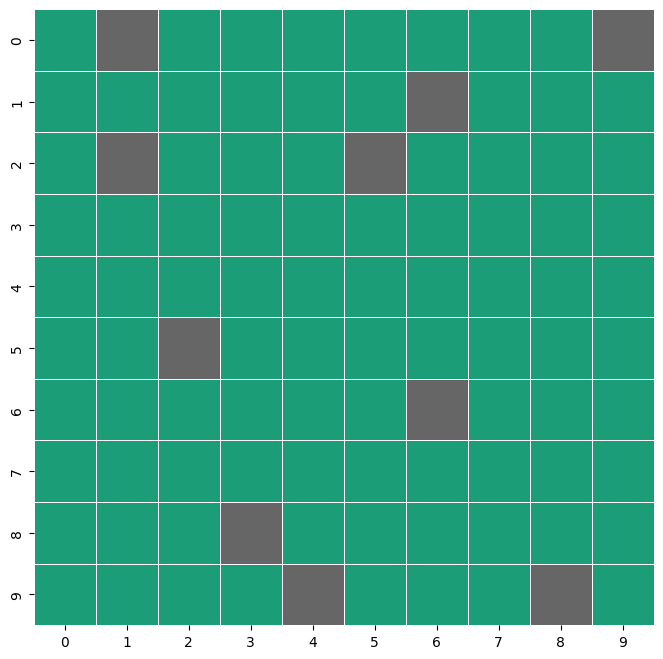

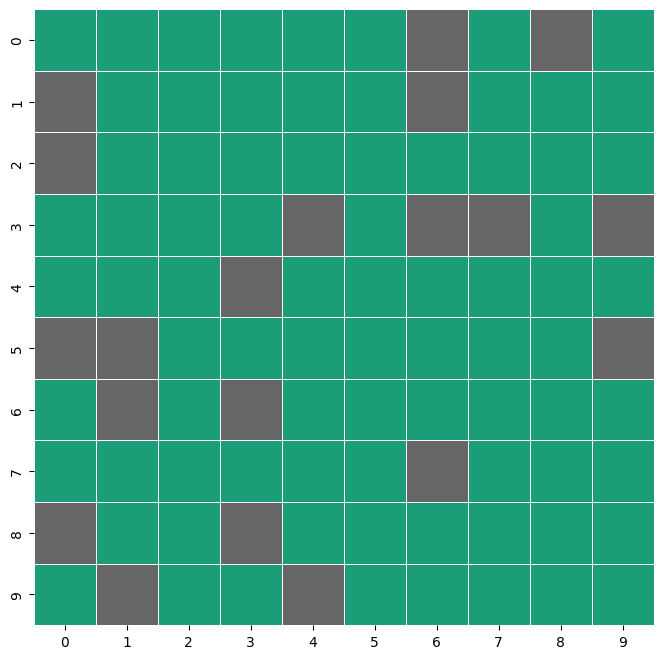

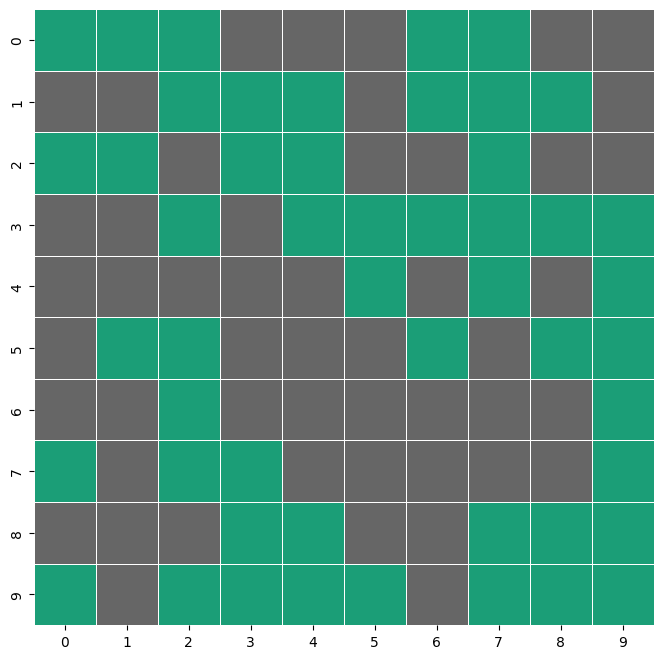

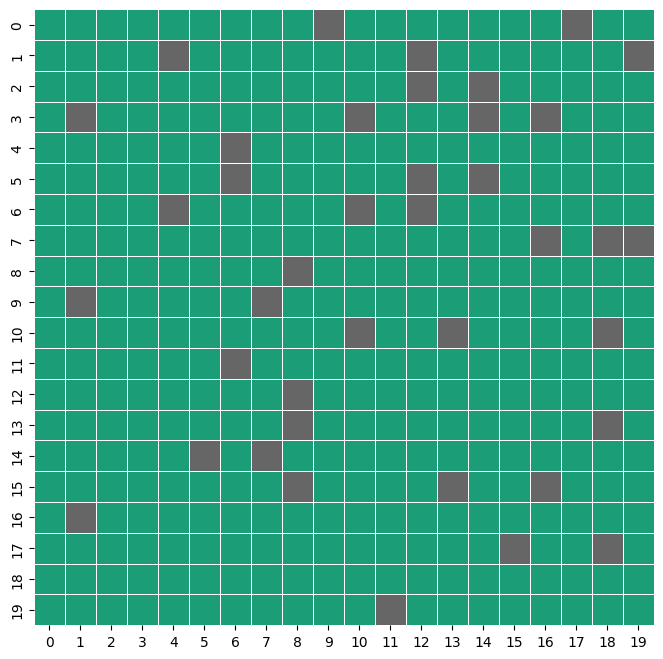

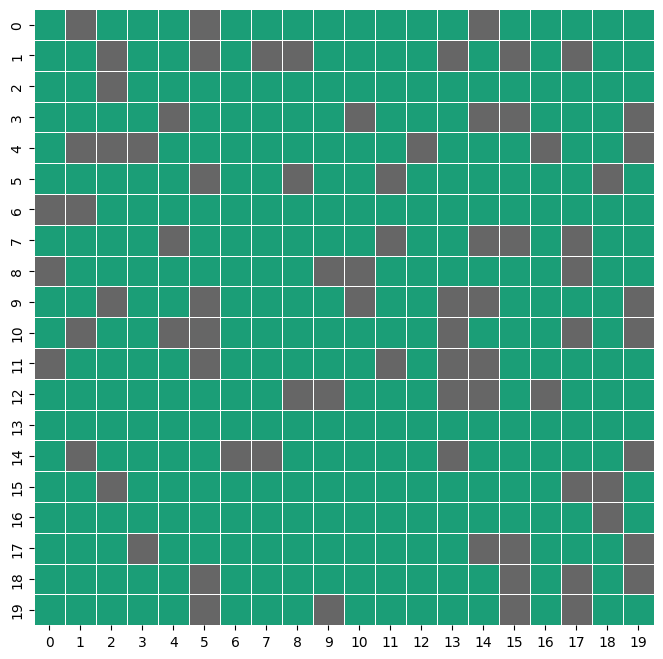

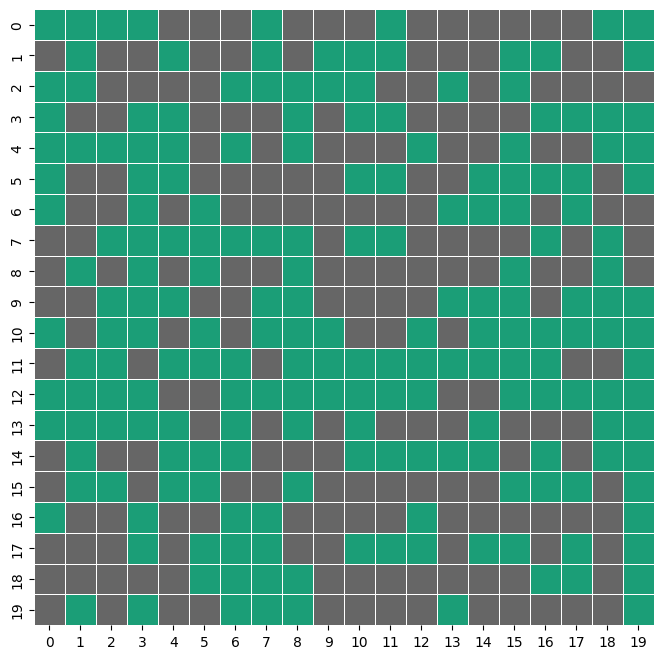

In [ ]:
for maze in maze_10_10:
    display_maze(maze)

for maze in maze_20_20:
    display_maze(maze)

In [ ]:
# Final version for the agent class.

import numpy as np

actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}     # Action space, actions as movements

class Agent(object):                                                 # define my agent class
    def __init__(self, maze, alpha=0.15, randomFactor=0.2):
        self.stateHistory = [((0,0), 0)]
        self.G = {}
        self.alpha = alpha
        self.randomFactor = randomFactor  # Define the randomFactor first
        self.initReward(maze.maze.shape)

    def chooseAction(self, state, allowedMoves):                    # encoding physics into the environment
        maxG = -10e15                                               # basis for comparison in the first move
        nextMove = None
        randomN = np.random.random()                                # pick a number from a random distribution, compares with random factor
        if randomN < self.randomFactor:
            nextMove = np.random.choice(allowedMoves)
        else:
            for action in allowedMoves:                              # iterate over the allowed moves and look for the
                newState = tuple([sum(x) for x in zip(state, actionSpace[action])]) # approximation of the  reward for
                if self.G[newState] >= maxG:                         # the new state, and then we compare it with our
                    maxG = self.G[newState]                          # best known reward
                    nextMove = action                                # if it is good we save it as our best reward and pick
        return nextMove                                              # the next move as the respective action.

    def initReward(self, maze_shape):
        rows, cols = maze_shape
        for y in range(rows):
            for x in range(cols):
                state = (y, x)
                if state not in self.G:
                    self.G[state] = np.random.uniform(low=-1.0, high=-0.1)


    def updateStateHistory(self, state, reward):           # To update our stateHistory, we want to pass in the new state
        self.stateHistory.append((state, reward))          # and reward, and we simply use the append function
                                                           # to append the state reward tuple to our list.


    def learn(self):    #this is called at the end of the episode when the agent has finished running the maze.
        target = 0      # we only learn when we beat the maze

        for prev, reward in reversed(self.stateHistory):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.stateHistory = []
        self.randomFactor = max(self.randomFactor - 10e-5, 0)                      # decrease the random factor at every step, gradually go from exploration to exploitation.



    def printG(self):
        for i in range(6):
            for j in range(6):
                if (i,j) in self.G.keys():
                    print('%.6f' % self.G[(i,j)], end='\t')
                else:
                    print('X', end='\t\t')
            print('\n')


Training on 10x10 maze with 10.0% walls - Game 0
Training on 10x10 maze with 20.0% walls - Game 0
Training on 10x10 maze with 50.0% walls - Game 0
Training on 20x20 maze with 10.0% walls - Game 0
Training on 20x20 maze with 20.0% walls - Game 0
Training on 20x20 maze with 50.0% walls - Game 0
Minimum steps for 10x10_10.0% maze: 24


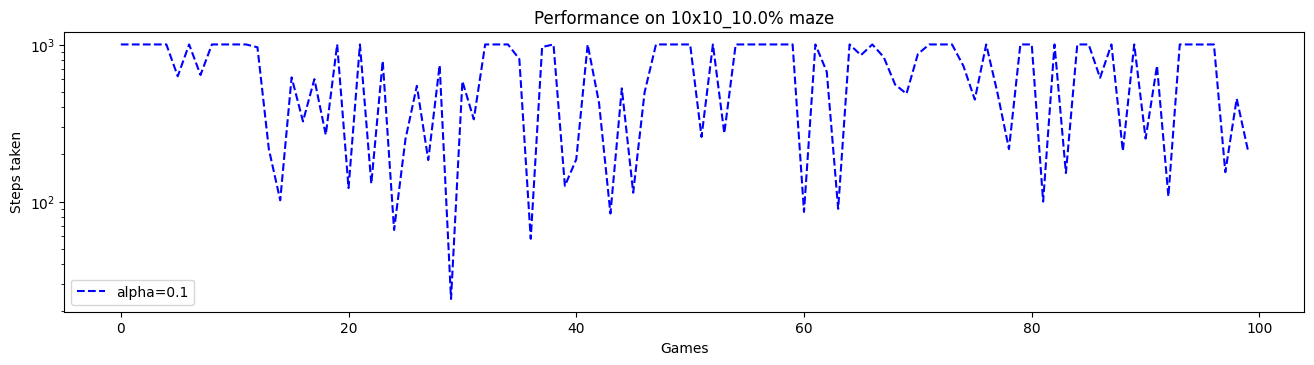

Minimum steps for 10x10_20.0% maze: 28


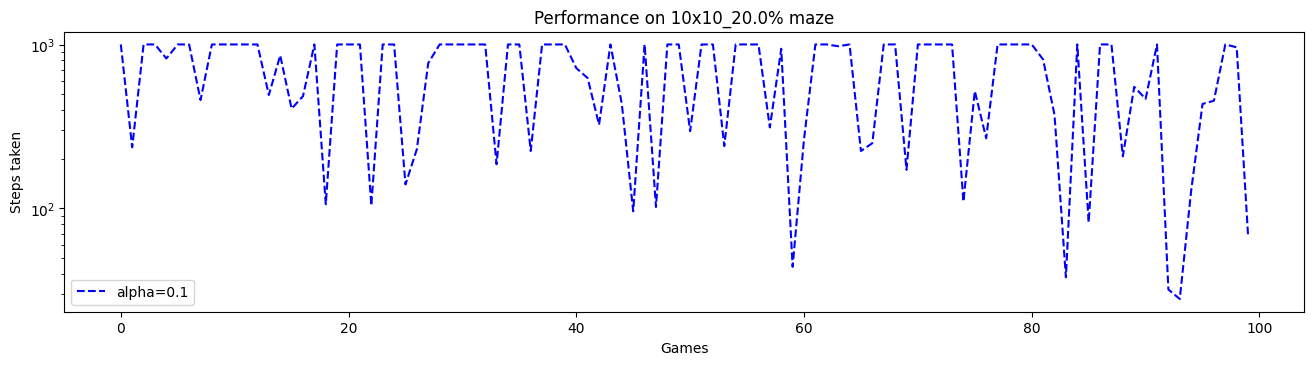

Minimum steps for 10x10_50.0% maze: 134


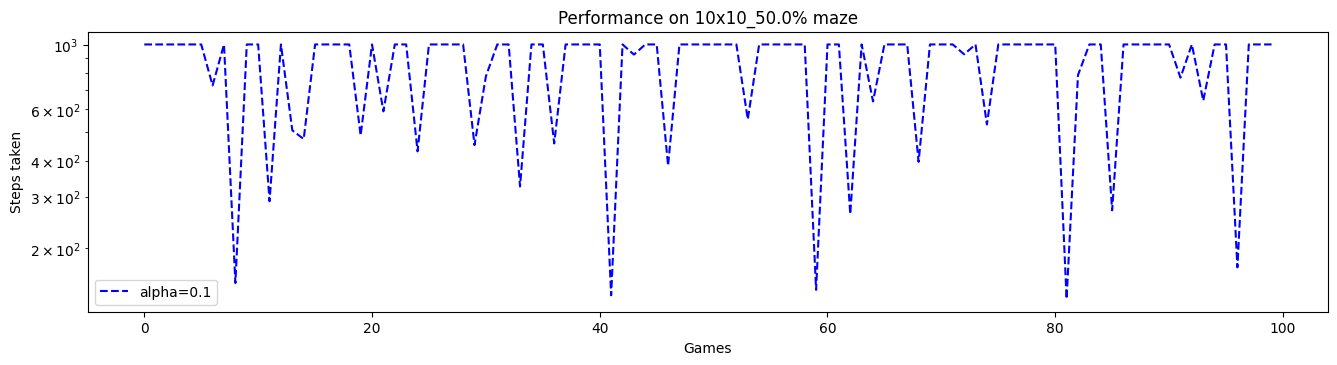

Minimum steps for 20x20_10.0% maze: 170


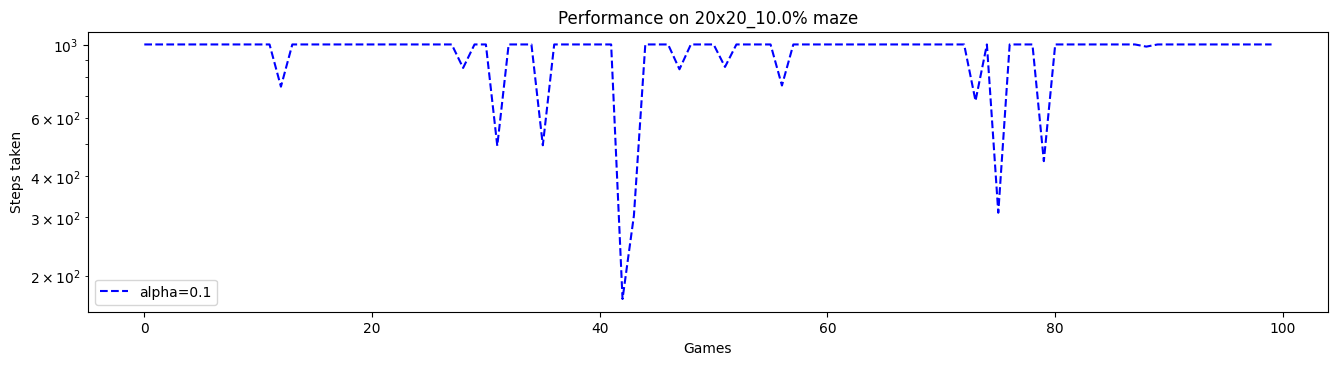

Minimum steps for 20x20_20.0% maze: 518


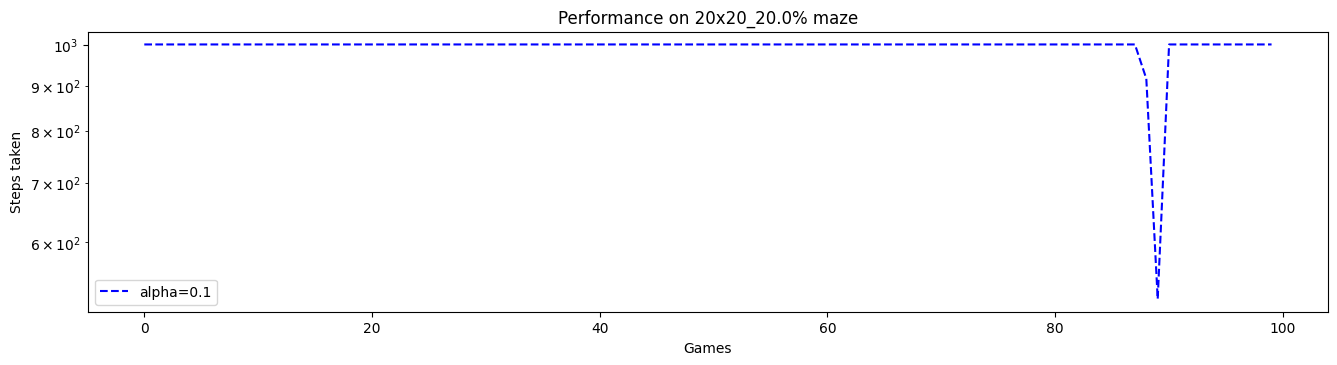

Minimum steps for 20x20_50.0% maze: 1001


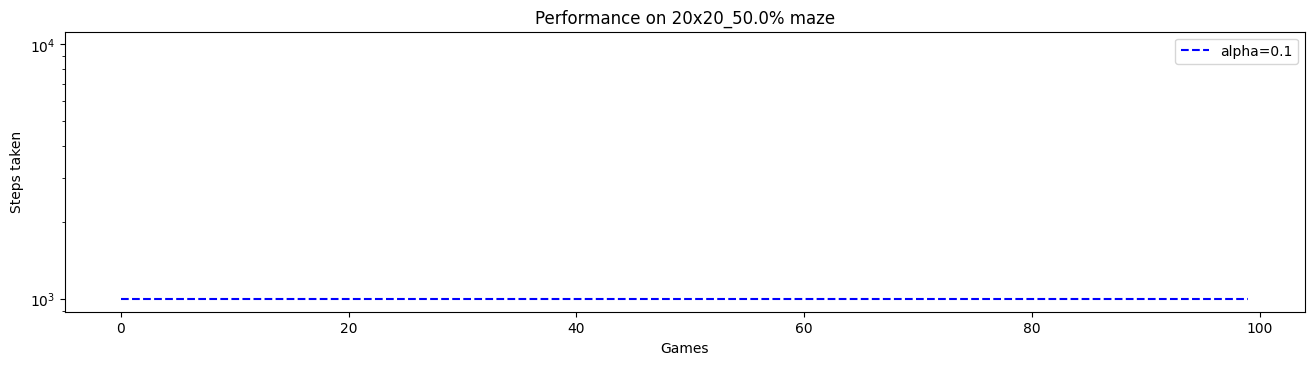

In [ ]:
def train_and_evaluate(dim, wall_percentage, alpha=0.1, randomFactor=0.2, num_games=100):
    maze = Maze(dim, wall_percentage)
    robot = Agent(maze, alpha=alpha, randomFactor=randomFactor)
    moveHistory = []

    for i in range(num_games):
        if i % 1000 == 0:
            print(f"Training on {dim}x{dim} maze with {wall_percentage*100:.1f}% walls - Game {i}")
        while not maze.isGameOver():
            state, _ = maze.getStateAndReward()
            action = robot.chooseAction(state, maze.allowedStates[state])
            maze.updateMaze(action)
            state, reward = maze.getStateAndReward()
            robot.updateStateHistory(state, reward)
            if maze.steps > 1000:  # Safety break to prevent infinite loop
                maze.robotPosition = (dim-1, dim-1)
        robot.learn()
        moveHistory.append(maze.steps)
        maze.reset()

    return min(moveHistory), moveHistory

# Train and evaluate all mazes
results = {}
moveHistories = {}
for dim, wall_percentages in [(10, [0.10, 0.20, 0.50]), (20, [0.10, 0.20, 0.50])]:
    for wall_percentage in wall_percentages:
        key = f"{dim}x{dim}_{wall_percentage*100:.1f}%"
        results[key], moveHistories[key] = train_and_evaluate(dim, wall_percentage)

# Print results and plot
for key in results.keys():
    print(f"Minimum steps for {key} maze: {results[key]}")
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.semilogy(moveHistories[key], 'b--')
    plt.title(f"Performance on {key} maze")
    plt.xlabel("Games")
    plt.ylabel("Steps taken")
    plt.legend([f"alpha=0.1"])
    plt.show()


In [ ]:
# Define possible values for Alpha and randomFactor to search through
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
random_factors = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

best_alpha = None
best_random_factor = None
best_avg_steps = float('inf')

# Create the 10x10 maze with 20% walls
maze_template = create_valid_maze(10, 0.20)
fastest_steps = float('inf')
best_fastest_steps = float('inf')
# Search through the hyperparameter space
for alpha in alphas:
    for random_factor in random_factors:
        total_steps = 0

        # Simulate the agent's behavior multiple times to get a reliable average
        for _ in range(100):
            maze_instance = Maze(dim=10, wall_percentage=0.20)
            maze_instance.maze = maze_template.copy()
            robot = Agent(maze_instance, alpha=alpha, randomFactor=random_factor)

            while not maze_instance.isGameOver():
                state, _ = maze_instance.getStateAndReward()
                action = robot.chooseAction(state, maze_instance.allowedStates[state])
                maze_instance.updateMaze(action)
                state, reward = maze_instance.getStateAndReward()
                robot.updateStateHistory(state, reward)
                if maze_instance.steps > 500:
                    break

            total_steps += maze_instance.steps
            if maze_instance.steps < fastest_steps:
                fastest_steps = maze_instance.steps

        avg_steps = total_steps / 100

        # Check if the current hyperparameter combination is better
        if avg_steps < best_avg_steps:
            best_alpha = alpha
            best_random_factor = random_factor
            best_avg_steps = avg_steps
            best_avg_steps = avg_steps
            best_fastest_steps = fastest_steps

print(f"Best Alpha: {best_alpha}")
print(f"Best Random Factor: {best_random_factor}")
print(f"Best Average Steps: {best_avg_steps}")
print(f"Best Fastest Steps: {best_fastest_steps}")



Best Alpha: 0.7
Best Random Factor: 0.5
Best Average Steps: 428.27
Best Fastest Steps: 60


# Källor

---

OpenAI. (2023). Code Generated by ChatGPT (4.0) [Code]. <br>
Notis. ChatGPT användes i arbetet för att speglas med och producera kod som resulterade i ett förbättrat
program vilket inte skulle ha varit möjligt utan AI stöd.